In [2]:
%load_ext autoreload
%autoreload 2

# PriorVAE: comparing shuffled data at each epoch vs non-shuffled

In [3]:
from jax import random
import dill
from numpyro.infer import Predictive


In [4]:
path = "./learnt_models/12/12_args.dill"

with open(path, "rb") as f:
    args = dill.load(f)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
from reusable.gp import OneDGP

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))

plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

# Comparing training plots

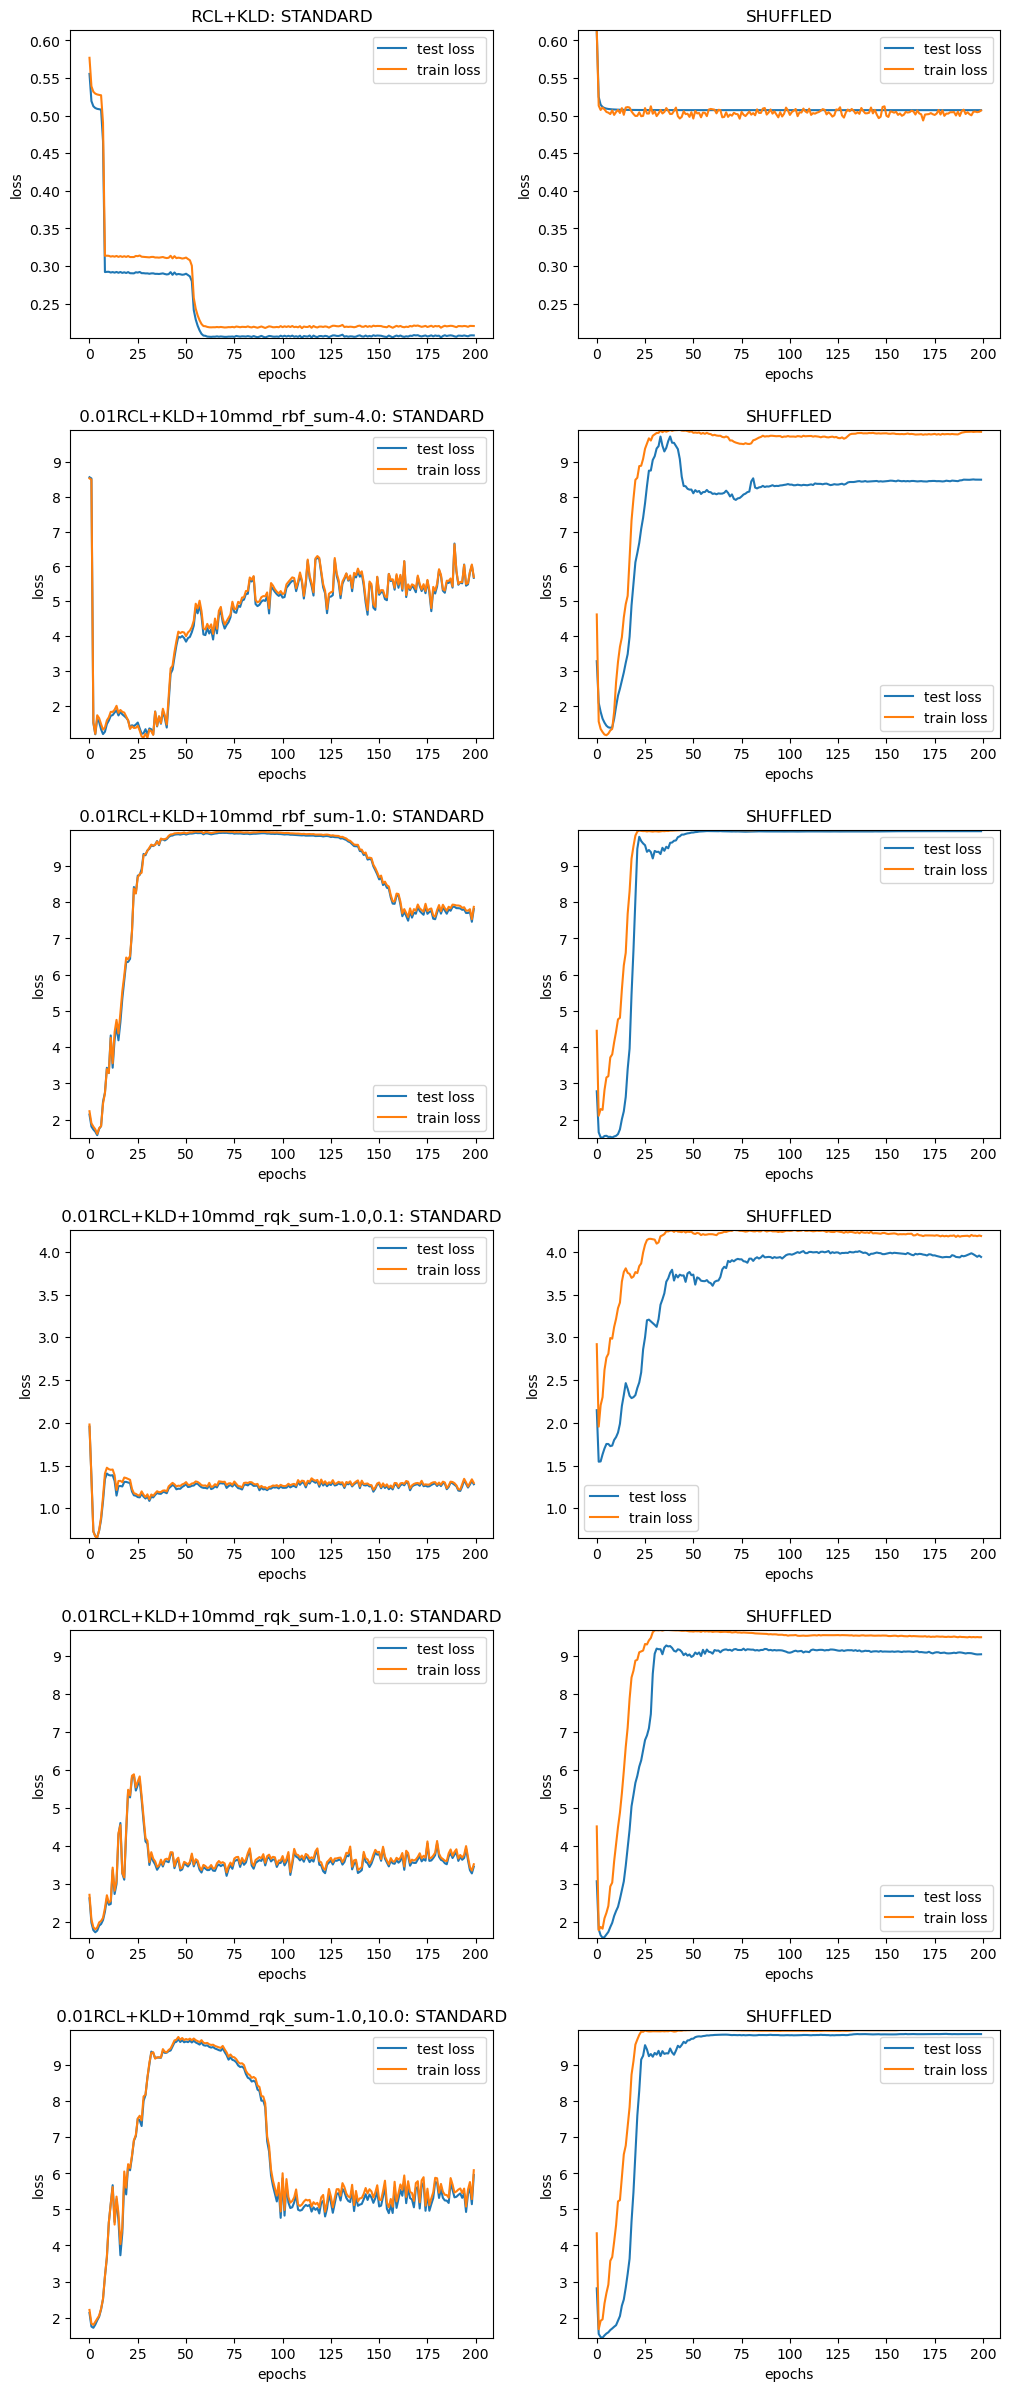

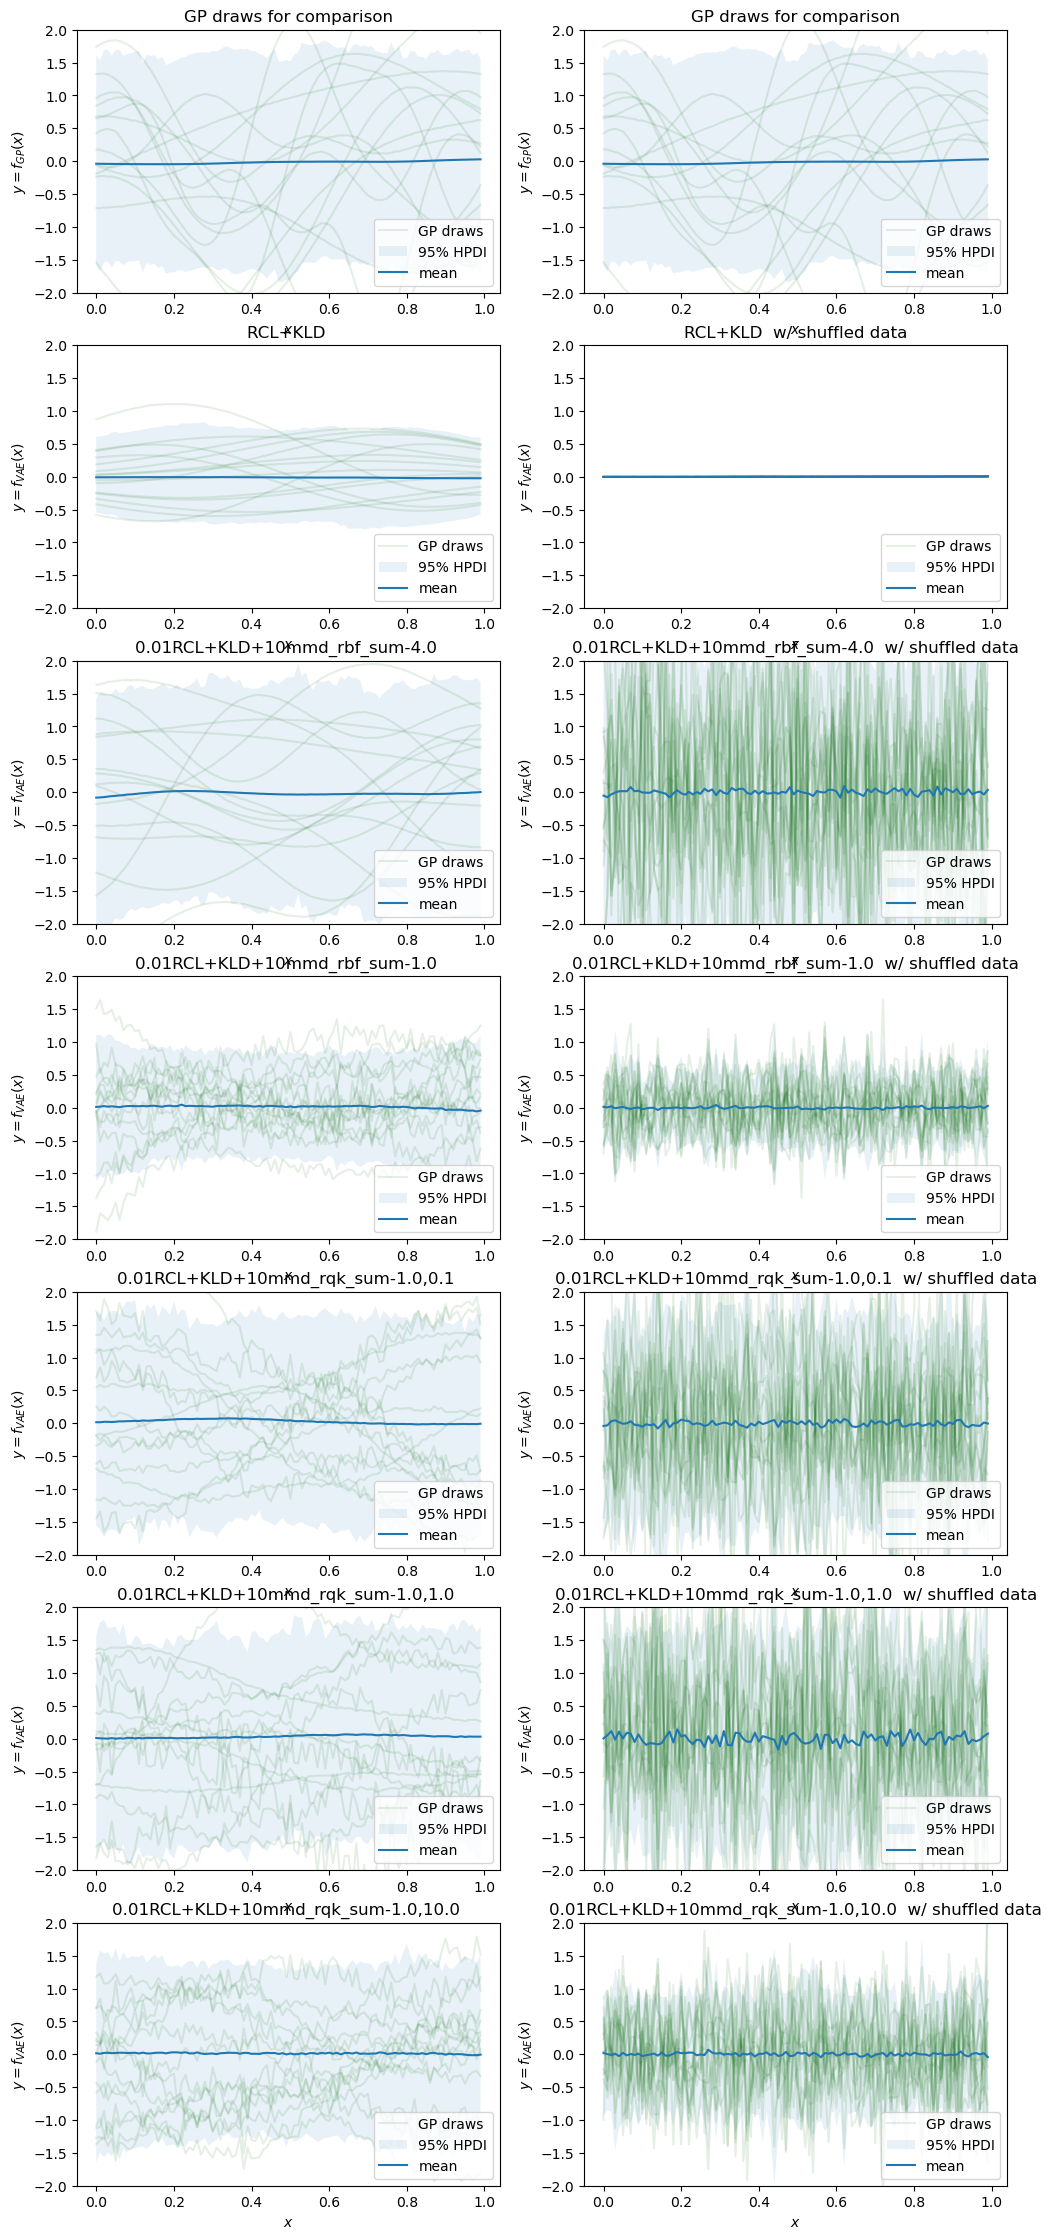

In [7]:
from reusable.util import get_savepath, decoder_filename
import matplotlib.pyplot as plt
from plotting.plots import plot_training_pair, plot_draws_hpdi
from reusable.vae import VAE, vae_sample
from flax import serialization
import jax.numpy as jnp
from flax.core.frozen_dict import freeze

fig = plt.figure(figsize=(12, 4 * len(args["loss_fns"])))
training_figs = fig.subfigures(nrows=len(args["loss_fns"]), ncols=1)

draws_fig, draws_axs = plt.subplots(
    nrows=len(args["loss_fns"]) + 1, ncols=2, figsize=(12, 4 * len(args["loss_fns"]) + 4)
)

for j in [0,1]:
    plot_draws_hpdi(
                gp_draws,
                args["x"],
                f"GP draws for comparison",
                "$y=f_{GP}(x)$",
                ax=draws_axs[0, j],
            )


for i, loss_fn in enumerate(args["loss_fns"]):
    loss_fn = str.replace(loss_fn, ":", "-")
    file_path = f'{get_savepath()}/{decoder_filename("12/12", args, suffix=loss_fn)}'
    st_path = file_path+ "_standard"+"_metrics_hist"
    sh_path = file_path + "_shuffle"+"_metrics_hist"
    try:
        with open(st_path, "rb") as file:
            metrics_history = dill.load(file)
        try: 
            with open(sh_path, "rb") as file:
                inf_metrics_history = dill.load(file)

            plot_training_pair(
                metrics_history["test_loss"],
                metrics_history["train_loss"],
                inf_metrics_history["test_loss"],
                inf_metrics_history["train_loss"],
                f" {loss_fn}: STANDARD ",
                f"SHUFFLED",
                "loss",
                fig=training_figs[i],
            )

        except FileNotFoundError:
            print(f"Failed to load metrics history shuffle for loss_fn={loss_fn}, at path {sh_path}")

    except FileNotFoundError:
        print(f"Failed to load metrics history standard for loss_fn={loss_fn}, at path {st_path}")
      


    for j in [0,1]:
        suffix2 = "_shuffle" if j ==1 else "_standard"
        str_shuffled = " w/ shuffled data" if j ==1 else ""
        file_path =  f'{get_savepath()}/{decoder_filename("12/12", args, suffix=loss_fn+suffix2)}'

        try:
            dummy = VAE(
                        hidden_dim1=args["hidden_dim1"], hidden_dim2=args["hidden_dim2"], latent_dim=args["latent_dim"], out_dim=args["n"], conditional=False
                    )
            dummy_params = dummy.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))


            with open(file_path, "rb") as file:
                bytes = file.read()
                new_state =  serialization.from_bytes(dummy_params, bytes)
                args["decoder_params"] = freeze({"params": new_state["params"]["VAE_Decoder_0"]})

            plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
            vae_draws = plot_vae_predictive(
                rng_key_predict,
                hidden_dim1=args["hidden_dim1"],
                hidden_dim2=args["hidden_dim2"],
                latent_dim=args["latent_dim"],
                out_dim=args["n"],
                decoder_params=args["decoder_params"],
            )["f"]

            plot_draws_hpdi(
                vae_draws,
                args["x"],
                f"{loss_fn} {str_shuffled}",
                "$y=f_{VAE}(x)$",
                ax=draws_axs[i+1, j],
            )
        except FileNotFoundError:
            print(f"Failed to load decoder params for loss_fn={loss_fn}, j={j} at path {file_path}")



        
